In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# read Covid-19 SG dataset
sg_data = pd.read_csv(url)
sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

In [3]:
sg_data_filtered.tail()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
643,2021-10-27,5324,0.0,184419,3172,0,151602,30713,1747,10,...,9662.0,450.0,NaN,NaN,Stabilisation Phase,10029148.0,4733014.0,4673461.0,85%,84%
644,2021-10-28,3432,0.0,187851,4348,0,155950,29827,1702,15,...,9936.0,430.0,NaN,NaN,Stabilisation Phase,10049015.0,4734669.0,4675888.0,85%,84%
645,2021-10-29,4248,0.0,192099,3011,0,158961,31166,1584,16,...,10018.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
646,2021-10-30,3112,0.0,195211,3912,0,162873,30339,1597,14,...,10372.0,396.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%
647,2021-10-31,3163,0.0,198374,3759,0,166632,29685,1642,13,...,10506.0,414.0,NaN,NaN,Stabilisation Phase,NaN,NaN,NaN,85%,84%


In [4]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          648 non-null    object 
 1   Daily Confirmed                               648 non-null    int64  
 2   False Positives Found                         539 non-null    float64
 3   Cumulative Confirmed                          648 non-null    int64  
 4   Daily Discharged                              648 non-null    int64  
 5   Passed but not due to COVID                   648 non-null    int64  
 6   Cumulative Discharged                         648 non-null    int64  
 7   Discharged to Isolation                       648 non-null    int64  
 8   Still Hospitalised                            648 non-null    int64  
 9   Daily Deaths                                  648 non-null    int

In [5]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [6]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [7]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [8]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [9]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [10]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [11]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               648 non-null    int64  
 1   False Positives Found                         648 non-null    float64
 2   Cumulative Confirmed                          648 non-null    int64  
 3   Daily Discharged                              648 non-null    int64  
 4   Passed but not due to COVID                   648 non-null    int64  
 5   Cumulative Discharged                         648 non-null    int64  
 6   Discharged to Isolation                       648 non-null    int64  
 7   Still Hospitalised                            648 non-null    int64  
 8   Daily Deaths                                  648 non-null    int64  
 9   Cumulative Deaths                             648 non-null    int

<AxesSubplot:>

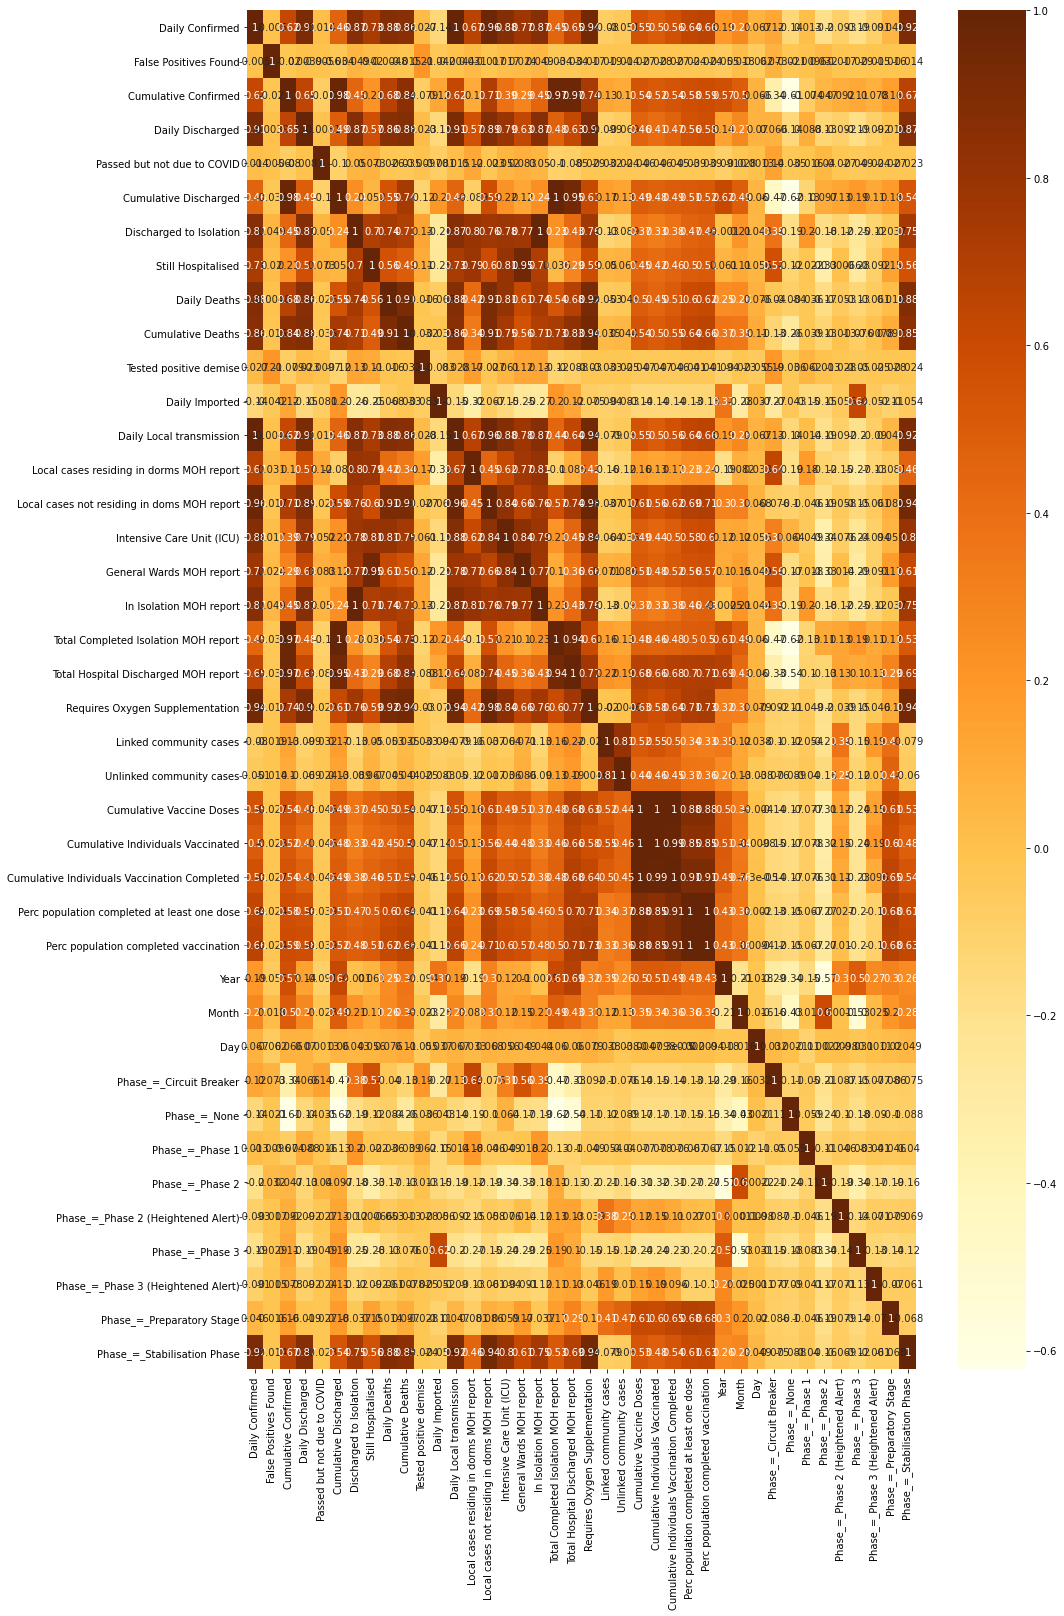

In [12]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [13]:
sg_data_filtered.corr()["Requires Oxygen Supplementation"].sort_values(ascending=False)

Requires Oxygen Supplementation                 1.000000
Local cases not residing in doms MOH report     0.979758
Daily Confirmed                                 0.940522
Daily Local transmission                        0.939762
Phase_=_Stabilisation Phase                     0.938299
Cumulative Deaths                               0.938014
Daily Deaths                                    0.921448
Daily Discharged                                0.903323
Intensive Care Unit (ICU)                       0.843608
Total Hospital Discharged MOH report            0.770736
Discharged to Isolation                         0.760613
In Isolation MOH report                         0.759711
Cumulative Confirmed                            0.739592
Perc population completed vaccination           0.730528
Perc population completed at least one dose     0.714017
General Wards MOH report                        0.655215
Cumulative Individuals Vaccination Completed    0.636723
Cumulative Vaccine Doses       

# Train Test Split & KFold Cross Validation

In [14]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Requires Oxygen Supplementation", axis=1)
y = sg_data_filtered["Requires Oxygen Supplementation"]

In [15]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear regression

In [17]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [18]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 4.789242481333741
MSE: 69.59454409284074
RMSE: 8.342334451029924
R-squared score for train: 0.993163415823208
Adjusted R-squared score for train: 0.9927248849302888
R-squared score for test: 0.9878023795399987
Adjusted R-squared score for test: 0.987019966385492
Cross Validation Score: 0.9882


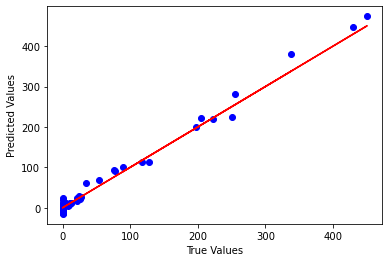

In [19]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

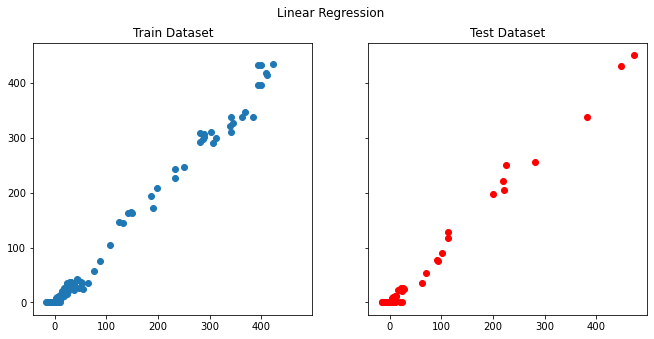

In [20]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [21]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
11,Daily Imported,1.877811e+08
12,Daily Local transmission,1.877811e+08
25,Perc population completed at least one dose,7.033624e+02
38,Phase_=_Stabilisation Phase,2.607366e+01
31,Phase_=_None,1.646894e+01
37,Phase_=_Preparatory Stage,6.985784e+00
7,Still Hospitalised,5.249522e+00
6,Discharged to Isolation,5.247266e+00
5,Cumulative Discharged,5.070541e+00
9,Cumulative Deaths,5.057685e+00


# Ridge Regression

In [22]:
## Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54155e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [23]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 4.758268097652818
MSE: 81.20870359252277
RMSE: 9.011587184981499
R-squared score for train: 0.9906460848095962
Adjusted R-squared score for train: 0.9900460803812643
R-squared score for test: 0.9857668017316283
Adjusted R-squared score for test: 0.9848538169742821
Cross Validation Score: 0.9877


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54155e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.2203e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.57982e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.22687e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.03295e-17): result may not be accurate.

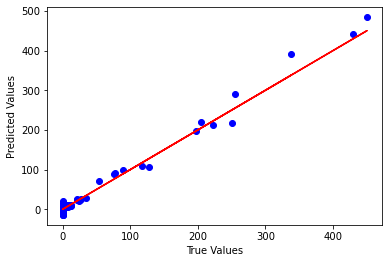

In [24]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

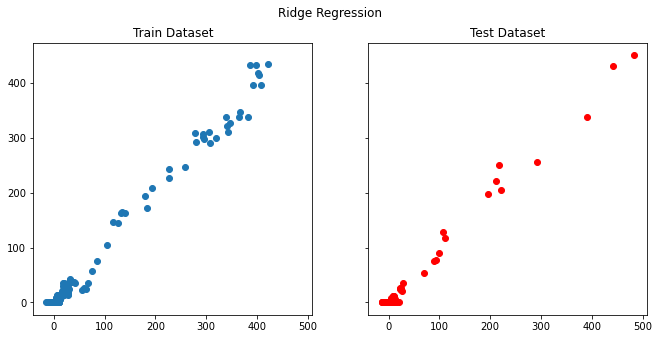

In [25]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [26]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
31,Phase_=_None,19.359259
25,Perc population completed at least one dose,8.838212
7,Still Hospitalised,5.543438
6,Discharged to Isolation,5.539697
9,Cumulative Deaths,5.492107
5,Cumulative Discharged,5.399393
38,Phase_=_Stabilisation Phase,5.130136
33,Phase_=_Phase 2,2.862559
36,Phase_=_Phase 3 (Heightened Alert),2.559660
34,Phase_=_Phase 2 (Heightened Alert),2.201503


# Important Features & Future Prediction

In [27]:
important_X = X[["Perc population completed vaccination","Still Hospitalised","Discharged to Isolation","Cumulative Discharged","Cumulative Deaths","Perc population completed at least one dose","Tested positive demise","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Perc population completed vaccination","Still Hospitalised","Discharged to Isolation","Cumulative Discharged","Cumulative Deaths","Perc population completed at least one dose","Tested positive demise","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed vaccination","Still Hospitalised","Discharged to Isolation","Cumulative Discharged","Cumulative Deaths","Perc population completed at least one dose","Tested positive demise","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [28]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [29]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 7.039581980464964
MSE: 203.03792478454037
RMSE: 14.24913768564752
R-squared score for train: 0.9777654464921905
Adjusted R-squared score for train: 0.9770927450325594
R-squared score for test: 0.9644141709987454
Adjusted R-squared score for test: 0.963337529675459
Cross Validation Score: 0.9718


# XGBoost

In [30]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=5)
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.7,
 'min_child_weight': 6,
 'max_depth': 3,
 'colsample_bytree': 0.8}

In [31]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.7, max_depth=3, colsample_bytree=0.8, min_child_weight=6)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 1.9412421211922684
MSE: 32.33957422962672
RMSE: 5.686789448329058
R-squared score for train: 0.9994499257384872
Adjusted R-squared score for train: 0.9994332833643332
R-squared score for test: 0.994331942863728
Adjusted R-squared score for test: 0.9941604570586496
Cross Validation Score: 0.9966


# Prediction with XGBoost

In [32]:
future_prediction = pd.DataFrame(data={
    "Perc population completed vaccination":[90],
    "Still Hospitalised":[1800],
    "Discharged to Isolation":[45000],
    "Cumulative Discharged":[250000],
    "Cumulative Deaths":[600],
    "Perc population completed at least one dose":[91],
    "Tested positive demise":[0],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)

In [33]:
xgb_fut_pred
# 420 require oxygen supplementation on 14 Dec 2021

array([419.90085], dtype=float32)